In [2]:
!pip install -U wandb

Requirement already up-to-date: wandb in /usr/local/lib/python3.7/dist-packages (0.10.24)


# PART B

In [3]:
# import necessary libraries
import os
import glob
import wandb
from wandb.keras import WandbCallback
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import numpy as np 

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
def load_data(input_shape=(256,256)):

    DATA_DIR = r"/content/drive/MyDrive/inaturalist_12K"

    train_dir = os.path.join(DATA_DIR, "train")
    val_dir = os.path.join(DATA_DIR, "val")

    train_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=50,
                                    zoom_range=0.2,
                                    shear_range=0.2,
                                    horizontal_flip=True)
    val_generator =ImageDataGenerator(rescale=1./255)

    train_ds = train_generator.flow_from_directory(train_dir, target_size=input_shape, batch_size=128, shuffle=True)
    val_ds = val_generator.flow_from_directory(val_dir, target_size=input_shape, batch_size=128)

    return train_ds, val_ds

train_ds, val_ds = load_data()

Found 10000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [5]:
## Utility functions for plotting ##
def plot_sample_images(dir_path):

    subdirs = glob.glob(os.path.join(dir_path,r"*"))

    fig_height = len(subdirs)//5 

    if len(subdirs)%5 != 0:
        fig_height+=1

    fig, axs = plt.subplots(fig_height, 5, figsize=(10, fig_height*2))
    fig.suptitle("Sample images from each class")
    axs = axs.reshape(-1)

    for i, subdir in enumerate(subdirs):

        class_name = os.path.basename(subdir)
        axs[i].set_title(class_name)
        
        img_path = glob.glob(os.path.join(subdir, r"*"))[0]
        img = mpimg.imread(img_path)    
        axs[i].imshow(img)

    plt.show()

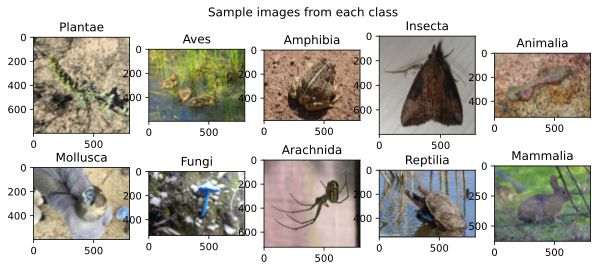

In [6]:
DATA_DIR = r"/content/drive/MyDrive/inaturalist_12K"
plot_sample_images(os.path.join(DATA_DIR,"train"))

In [7]:
class NeuralNet(tf.keras.Model):    
    def __init__(self, base_model, image_shape=(256, 256)):
        super(NeuralNet, self).__init__()

        # instantiating the base model and freezing it's weights
        self.base_model = self.select_model(base_model, image_shape)
        self.base_model.trainable=False

        # The layers below form the classification head 
        self.conv1 = layers.Conv1D(3, 12, 6, activation="relu")
        self.pool1 = layers.MaxPool1D(3,3)
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv1D(3, 6, 3, activation="relu")
        self.pool2 = layers.MaxPool1D(3,3)
        self.bn2 = layers.BatchNormalization()
        self.output_layer = layers.Dense(10, activation=None)

    @staticmethod
    def select_model(name, image_shape):
        
        image_shape = list(image_shape)
        image_shape.append(3)
        
        INPUT_SHAPE = tuple(image_shape) 

        if name=="InceptionV3":
            return tf.keras.applications.InceptionV3(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
        elif name=="InceptionResNetV2":
            return tf.keras.applications.InceptionResNetV2(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
        elif name=="ResNet50":
            return tf.keras.applications.ResNet50(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
        elif name=="Xception":
            return tf.keras.applications.Xception(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')

    def call(self, x):
        x = layers.Flatten()(self.base_model(x))
        
        x = tf.expand_dims(x, -1)
        x = self.bn1(self.pool1(self.conv1(x)))
        x = self.bn2(self.pool2(self.conv2(x)))
        x = layers.Flatten()(x)

        return self.output_layer(x)

In [10]:
## checking the model
test_model = NeuralNet("ResNet50 ")
x = tf.random.uniform((64,256,256,3))
x = test_model(x)

print(len(test_model.trainable_variables))
print(len(test_model.base_model.layers))

"""
# Fine-tune from this layer onwards
test_model.base_model.trainable = True
print(len(test_model.trainable_variables))


fine_tune_at = len(test_model.base_model.layers) - 30

# Freeze all the layers before the `fine_tune_at` layer
for layer in test_model.base_model.layers[:fine_tune_at]:
    layer.trainable =  False

print(len(test_model.trainable_variables))
"""

test_model.base_model.summary()

10
175
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________

## Preliminary Run - No fine tuning


In [15]:
def train_with_wandb(image_shape=(256, 256), epochs=30, fine_tune_epochs=10):

    config_defaults = {"base_model": "InceptionV3"}

    wandb.init(config=config_defaults, project="cs6910-assignment2", magic=True)

    ## 1. Data loading
    print("1. Loading the dataset ...\n")
    train_ds, val_ds = load_data(image_shape)

    ## 2. Initializing the model
    print("2. Initializing the model ...\n")
    model = NeuralNet(wandb.config.base_model, image_shape=image_shape)

    ## 3. Compiling the model
    base_learning_rate = 0.0002

    print("3. Compiling the model ...\n")
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    ## 4. Fitting the model
    print("4. Fitting the model ...\n")
    model.fit(train_ds, 
              validation_data=val_ds,
              epochs=epochs,
              callbacks=[WandbCallback()])
    print("Model trained successfully!!\n")

    ## 5. Fine tuning the model
    to_tune_defaults = {
        "InceptionV3": 55,
        "InceptionResNetV2": 55,
        "ResNet50": 50,
        "Xception": 50
    }
    
    model.base_model.trainable = True
    print(f"Total layers in base model is {len(model.base_model.layers)}\n")

    fine_tune_at = len(model.base_model.layers) - to_tune_defaults[wandb.config.base_model]

    for layer in model.base_model.layers[:fine_tune_at]:
        layer.trainable =  False

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    print("Fine tuning the model ...\n")
    model.fit(train_ds, 
              validation_data=val_ds,
              epochs=fine_tune_epochs,
              callbacks=[WandbCallback()])
    print("Model tuned successfully!!\n")


In [13]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
## Setting up the sweep ##
sweep_config = {
  "name": "My Sweep",
  "method": "grid",
  "parameters": {
        "base_model": {
            "values": ["InceptionV3", "InceptionResNetV2", "ResNet50", "Xception"]
        }
    }
}


sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: wbr7x3ie
Sweep URL: https://wandb.ai/avyay-sujay/uncategorized/sweeps/wbr7x3ie


In [ ]:
# Running the sweep
wandb.agent(sweep_id, function=train_with_wandb)

wandb: Agent Starting Run: j9xeem63 with config:
wandb: 	base_model: InceptionV3
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Loading the dataset ...
Found 10000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Initializing the model ...
Compiling the model ...
Fitting the model ...
Epoch 1/6
79/79 [==============================] - 2353s 30s/step - loss: 3.1173 - accuracy: 0.1121 - val_loss: 2.3830 - val_accuracy: 0.1370


wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


Epoch 2/6
79/79 [==============================] - 205s 3s/step - loss: 2.9485 - accuracy: 0.1345 - val_loss: 2.4525 - val_accuracy: 0.1485
Epoch 3/6
79/79 [==============================] - 203s 3s/step - loss: 2.8272 - accuracy: 0.1496 - val_loss: 2.5018 - val_accuracy: 0.1570
Epoch 4/6
79/79 [==============================] - 199s 3s/step - loss: 2.7427 - accuracy: 0.1545 - val_loss: 2.5237 - val_accuracy: 0.1725
Epoch 5/6
79/79 [==============================] - 200s 3s/step - loss: 2.6285 - accuracy: 0.1674 - val_loss: 2.5121 - val_accuracy: 0.1855
Epoch 6/6
79/79 [==============================] - 199s 3s/step - loss: 2.5741 - accuracy: 0.1785 - val_loss: 2.4753 - val_accuracy: 0.1945


epoch,5
loss,2.55493
accuracy,0.1818
val_loss,2.47525
val_accuracy,0.1945
_runtime,3394
_timestamp,1617362288
_step,5
best_val_loss,2.38305
best_epoch,0


epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
accuracy,▁▃▅▅▇█
val_loss,▁▄▇█▇▆
val_accuracy,▁▂▃▅▇█
_runtime,▁▂▄▅▇█
_timestamp,▁▂▄▅▇█
_step,▁▂▄▅▇█


wandb: Agent Starting Run: wsgex9sb with config:
wandb: 	base_model: InceptionResNetV2
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Loading the dataset ...
Found 10000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Initializing the model ...
Compiling the model ...
Fitting the model ...
Epoch 1/6
79/79 [==============================] - 225s 3s/step - loss: 3.0100 - accuracy: 0.0987 - val_loss: 2.5078 - val_accuracy: 0.1120


wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


Epoch 2/6
79/79 [==============================] - 205s 3s/step - loss: 2.7796 - accuracy: 0.1269 - val_loss: 2.4934 - val_accuracy: 0.1280
Epoch 3/6
79/79 [==============================] - 204s 3s/step - loss: 2.6542 - accuracy: 0.1506 - val_loss: 2.4575 - val_accuracy: 0.1640
Epoch 4/6
79/79 [==============================] - 205s 3s/step - loss: 2.5333 - accuracy: 0.1736 - val_loss: 2.4037 - val_accuracy: 0.1855
Epoch 5/6
79/79 [==============================] - 206s 3s/step - loss: 2.4241 - accuracy: 0.1962 - val_loss: 2.3354 - val_accuracy: 0.2055
Epoch 6/6
79/79 [==============================] - 205s 3s/step - loss: 2.3451 - accuracy: 0.2061 - val_loss: 2.2650 - val_accuracy: 0.2235


epoch,5
loss,2.32545
accuracy,0.2113
val_loss,2.26505
val_accuracy,0.2235
_runtime,1272
_timestamp,1617363568
_step,5
best_val_loss,2.26505
best_epoch,5


epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
accuracy,▁▃▅▆▇█
val_loss,██▇▅▃▁
val_accuracy,▁▂▄▆▇█
_runtime,▁▂▄▅▇█
_timestamp,▁▂▄▅▇█
_step,▁▂▄▅▇█


wandb: Agent Starting Run: qreotkta with config:
wandb: 	base_model: ResNet50
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Loading the dataset ...
Found 10000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Initializing the model ...
94773248/94765736 [==============================] - 1s 0us/step
Compiling the model ...
Fitting the model ...
Epoch 1/6
79/79 [==============================] - 219s 3s/step - loss: 2.4772 - accuracy: 0.1021 - val_loss: 2.4405 - val_accuracy: 0.0995


wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


Epoch 2/6
79/79 [==============================] - 207s 3s/step - loss: 2.2999 - accuracy: 0.1176 - val_loss: 2.4035 - val_accuracy: 0.1015
Epoch 3/6
79/79 [==============================] - 205s 3s/step - loss: 2.2901 - accuracy: 0.1297 - val_loss: 2.4025 - val_accuracy: 0.1010
Epoch 4/6
79/79 [==============================] - 202s 3s/step - loss: 2.2765 - accuracy: 0.1461 - val_loss: 2.3482 - val_accuracy: 0.1015
Epoch 5/6
79/79 [==============================] - 203s 3s/step - loss: 2.2680 - accuracy: 0.1439 - val_loss: 2.3146 - val_accuracy: 0.1055
Epoch 6/6
79/79 [==============================] - 201s 3s/step - loss: 2.2657 - accuracy: 0.1478 - val_loss: 2.2781 - val_accuracy: 0.1485


epoch,5
loss,2.26433
accuracy,0.1493
val_loss,2.27813
val_accuracy,0.1485
_runtime,1248
_timestamp,1617364824
_step,5
best_val_loss,2.27813
best_epoch,5


epoch,▁▂▄▅▇█
loss,█▃▂▂▁▁
accuracy,▁▃▅▇██
val_loss,█▆▆▄▃▁
val_accuracy,▁▁▁▁▂█
_runtime,▁▂▄▅▇█
_timestamp,▁▂▄▅▇█
_step,▁▂▄▅▇█


wandb: Agent Starting Run: rkduwt2j with config:
wandb: 	base_model: Xception
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Loading the dataset ...
Found 10000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Initializing the model ...
83689472/83683744 [==============================] - 0s 0us/step
Compiling the model ...
Fitting the model ...
Epoch 1/6
79/79 [==============================] - 214s 3s/step - loss: 2.8980 - accuracy: 0.1179 - val_loss: 2.3256 - val_accuracy: 0.1530


wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


Epoch 2/6
79/79 [==============================] - 205s 3s/step - loss: 2.6148 - accuracy: 0.1560 - val_loss: 2.3299 - val_accuracy: 0.1620
Epoch 3/6
79/79 [==============================] - 205s 3s/step - loss: 2.4191 - accuracy: 0.1967 - val_loss: 2.2601 - val_accuracy: 0.1970
Epoch 4/6
79/79 [==============================] - 206s 3s/step - loss: 2.3049 - accuracy: 0.2260 - val_loss: 2.1692 - val_accuracy: 0.2410
Epoch 5/6
79/79 [==============================] - 204s 3s/step - loss: 2.2002 - accuracy: 0.2568 - val_loss: 2.0767 - val_accuracy: 0.2845
Epoch 6/6
79/79 [==============================] - 204s 3s/step - loss: 2.0950 - accuracy: 0.2926 - val_loss: 2.0038 - val_accuracy: 0.3115


epoch,5
loss,2.08797
accuracy,0.2937
val_loss,2.00384
val_accuracy,0.3115
_runtime,1246
_timestamp,1617366078
_step,5
best_val_loss,2.00384
best_epoch,5


epoch,▁▂▄▅▇█
loss,█▆▄▃▂▁
accuracy,▁▃▄▆▇█
val_loss,██▇▅▃▁
val_accuracy,▁▁▃▅▇█
_runtime,▁▂▄▅▇█
_timestamp,▁▂▄▅▇█
_step,▁▂▄▅▇█


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


## Single model (to figure out training epochs)

In [ ]:
## Checking for best hyperparamters
## Setting up the sweep ##
sweep_config2 = {
  "name": "My Sweep",
  "method": "grid",
  "parameters": {
        "base_model": {
            "values": ["InceptionV3"]
        }
    }
}


sweep_id2 = wandb.sweep(sweep_config2)

Create sweep with ID: 3zhizfac
Sweep URL: https://wandb.ai/avyay-sujay/uncategorized/sweeps/3zhizfac


In [ ]:
# running the sweep
wandb.agent(sweep_id2, function=train_with_wandb)

wandb: Agent Starting Run: 9aa7qnld with config:
wandb: 	base_model: InceptionV3
wandb: Currently logged in as: avyay-sujay (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: WARNING Ignored wandb.init() arg project when running a sweep


1. Loading the dataset ...
Found 10000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2. Initializing the model ...
3. Compiling the model ...
4. Fitting the model ...
Epoch 1/100
79/79 [==============================] - 4713s 60s/step - loss: 2.6677 - accuracy: 0.1342 - val_loss: 2.4975 - val_accuracy: 0.1390


wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


Epoch 2/100
79/79 [==============================] - 249s 3s/step - loss: 2.3247 - accuracy: 0.1925 - val_loss: 2.2079 - val_accuracy: 0.2210
Epoch 3/100
79/79 [==============================] - 237s 3s/step - loss: 2.1842 - accuracy: 0.2464 - val_loss: 2.0788 - val_accuracy: 0.2815
Epoch 4/100
79/79 [==============================] - 238s 3s/step - loss: 2.0818 - accuracy: 0.2697 - val_loss: 1.9762 - val_accuracy: 0.3245
Epoch 5/100
79/79 [==============================] - 232s 3s/step - loss: 1.9962 - accuracy: 0.3223 - val_loss: 1.9042 - val_accuracy: 0.3495
Epoch 6/100
79/79 [==============================] - 231s 3s/step - loss: 1.9401 - accuracy: 0.3430 - val_loss: 1.8361 - val_accuracy: 0.3835
Epoch 7/100
79/79 [==============================] - 234s 3s/step - loss: 1.8843 - accuracy: 0.3714 - val_loss: 1.7700 - val_accuracy: 0.4255
Epoch 8/100
79/79 [==============================] - 227s 3s/step - loss: 1.8300 - accuracy: 0.3974 - val_loss: 1.7160 - val_accuracy: 0.4525
Epoch 

wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
## Setting up the sweep ##
sweep_config3 = {
  "name": "My Sweep",
  "method": "grid",
  "parameters": {
        "base_model": {
            "values": ["InceptionV3"]
        }
    }
}


sweep_id3 = wandb.sweep(sweep_config3)

Create sweep with ID: ydf5gjzx
Sweep URL: https://wandb.ai/avyay-sujay/uncategorized/sweeps/ydf5gjzx


In [ ]:
# running the sweep
wandb.agent(sweep_id3, function=train_with_wandb)

wandb: Agent Starting Run: whty29a4 with config:
wandb: 	base_model: InceptionV3
wandb: Currently logged in as: avyay-sujay (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: WARNING Ignored wandb.init() arg project when running a sweep


1. Loading the dataset ...

Found 10000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2. Initializing the model ...

3. Compiling the model ...

4. Fitting the model ...

Epoch 1/2
79/79 [==============================] - 3631s 46s/step - loss: 2.8091 - accuracy: 0.1413 - val_loss: 2.3282 - val_accuracy: 0.1700


wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


Epoch 2/2
79/79 [==============================] - 264s 3s/step - loss: 2.4964 - accuracy: 0.2019 - val_loss: 2.1898 - val_accuracy: 0.2390
Model trained successfully!!

Total layers in base model is 311

Fine tuning the model ...

Epoch 1/2
79/79 [==============================] - 274s 3s/step - loss: 2.2568 - accuracy: 0.2683 - val_loss: 1.7784 - val_accuracy: 0.4105


wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


Epoch 2/2
79/79 [==============================] - 268s 3s/step - loss: 1.8167 - accuracy: 0.4131 - val_loss: 1.5159 - val_accuracy: 0.5125
Model tuned successfully!!



epoch,1
loss,1.77467
accuracy,0.4281
val_loss,1.51589
val_accuracy,0.5125
_runtime,4484
_timestamp,1617472739
_step,3
best_val_loss,1.51589
best_epoch,1


epoch,▁█▁█
loss,█▆▄▁
accuracy,▁▃▅█
val_loss,█▇▃▁
val_accuracy,▁▂▆█
_runtime,▁▃▆█
_timestamp,▁▃▆█
_step,▁▃▆█


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


## Final sweep

In [16]:
## Setting up the sweep ##
sweep_config_final = {
  "name": "My Sweep",
  "method": "grid",
  "parameters": {
        "base_model": {
            "values": [ "ResNet50", "Xception"]
        }
    }
}


sweep_id_final = wandb.sweep(sweep_config_final)

Create sweep with ID: lj7cwcop
Sweep URL: https://wandb.ai/avyay-sujay/uncategorized/sweeps/lj7cwcop


In [17]:
# running the sweep
wandb.agent(sweep_id_final, function=train_with_wandb)

wandb: Agent Starting Run: fjfw9a7h with config:
wandb: 	base_model: ResNet50
wandb: Currently logged in as: avyay-sujay (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: WARNING Ignored wandb.init() arg project when running a sweep


1. Loading the dataset ...

Found 10000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2. Initializing the model ...

3. Compiling the model ...

4. Fitting the model ...

Epoch 1/30
79/79 [==============================] - 3853s 49s/step - loss: 2.4636 - accuracy: 0.1136 - val_loss: 2.3667 - val_accuracy: 0.1235


wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


Epoch 2/30
79/79 [==============================] - 307s 4s/step - loss: 2.2778 - accuracy: 0.1456 - val_loss: 2.2931 - val_accuracy: 0.1580
Epoch 3/30
79/79 [==============================] - 299s 4s/step - loss: 2.2661 - accuracy: 0.1565 - val_loss: 2.2612 - val_accuracy: 0.1415
Epoch 4/30
79/79 [==============================] - 300s 4s/step - loss: 2.2431 - accuracy: 0.1639 - val_loss: 2.2326 - val_accuracy: 0.1625
Epoch 5/30
79/79 [==============================] - 294s 4s/step - loss: 2.2300 - accuracy: 0.1667 - val_loss: 2.2010 - val_accuracy: 0.1945
Epoch 6/30
79/79 [==============================] - 293s 4s/step - loss: 2.2204 - accuracy: 0.1865 - val_loss: 2.2027 - val_accuracy: 0.1780
Epoch 7/30
79/79 [==============================] - 293s 4s/step - loss: 2.2123 - accuracy: 0.1849 - val_loss: 2.1868 - val_accuracy: 0.1970
Epoch 8/30
79/79 [==============================] - 292s 4s/step - loss: 2.2026 - accuracy: 0.2009 - val_loss: 2.1759 - val_accuracy: 0.2125
Epoch 9/30
79

wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


Epoch 9/10
79/79 [==============================] - 298s 4s/step - loss: 2.0098 - accuracy: 0.2821 - val_loss: 2.0596 - val_accuracy: 0.2560
Epoch 10/10
79/79 [==============================] - 299s 4s/step - loss: 1.9897 - accuracy: 0.2912 - val_loss: 2.0834 - val_accuracy: 0.2605
Model tuned successfully!!



epoch,9
loss,1.99996
accuracy,0.2873
val_loss,2.08345
val_accuracy,0.2605
_runtime,15404
_timestamp,1617614940
_step,39
best_val_loss,2.03089
best_epoch,7


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███▁▁▁▂▂▂▂▃▃▃
loss,▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂█▄▃▃▂▂▂▁▁▁
accuracy,▁▂▃▃▃▄▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▆▆▆▅▆▆▆▆▆▃▄▅▅▆▆▇▇██
val_loss,▄▄▃▃▃▃▃▂▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂█▆▄▂▂▂▂▁▁▂
val_accuracy,▁▃▂▃▄▃▄▅▄▄▅▅▅▅▅▅▄▆▅▅▆▆▅▅▆▆▆▆▆▆▁▁▂▅▆▆▅█▇▇
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ku2ijhnb with config:
wandb: 	base_model: Xception
wandb: WARNING Ignored wandb.init() arg project when running a sweep


1. Loading the dataset ...

Found 10000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
2. Initializing the model ...

83689472/83683744 [==============================] - 0s 0us/step
3. Compiling the model ...

4. Fitting the model ...

Epoch 1/30
79/79 [==============================] - 313s 4s/step - loss: 2.5936 - accuracy: 0.1549 - val_loss: 2.2002 - val_accuracy: 0.1745


wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


Epoch 2/30
79/79 [==============================] - 299s 4s/step - loss: 2.0211 - accuracy: 0.3199 - val_loss: 2.0131 - val_accuracy: 0.2595
Epoch 3/30
79/79 [==============================] - 295s 4s/step - loss: 1.7035 - accuracy: 0.4427 - val_loss: 1.6948 - val_accuracy: 0.4665
Epoch 4/30
79/79 [==============================] - 303s 4s/step - loss: 1.4973 - accuracy: 0.5182 - val_loss: 1.4402 - val_accuracy: 0.5430
Epoch 5/30
79/79 [==============================] - 305s 4s/step - loss: 1.3486 - accuracy: 0.5779 - val_loss: 1.2103 - val_accuracy: 0.6380
Epoch 6/30
79/79 [==============================] - 302s 4s/step - loss: 1.2787 - accuracy: 0.5892 - val_loss: 1.1038 - val_accuracy: 0.6625
Epoch 7/30
79/79 [==============================] - 300s 4s/step - loss: 1.2251 - accuracy: 0.6077 - val_loss: 1.0521 - val_accuracy: 0.6775
Epoch 8/30
79/79 [==============================] - 299s 4s/step - loss: 1.1491 - accuracy: 0.6302 - val_loss: 1.0105 - val_accuracy: 0.6880
Epoch 9/30
79

wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


Epoch 2/10
79/79 [==============================] - 308s 4s/step - loss: 0.9976 - accuracy: 0.6725 - val_loss: 0.8123 - val_accuracy: 0.7510
Epoch 3/10
79/79 [==============================] - 308s 4s/step - loss: 0.9200 - accuracy: 0.6926 - val_loss: 0.8002 - val_accuracy: 0.7670
Epoch 4/10
79/79 [==============================] - 309s 4s/step - loss: 0.8441 - accuracy: 0.7174 - val_loss: 0.7715 - val_accuracy: 0.7720
Epoch 5/10
79/79 [==============================] - 310s 4s/step - loss: 0.7745 - accuracy: 0.7479 - val_loss: 0.7473 - val_accuracy: 0.7740
Epoch 6/10
79/79 [==============================] - 312s 4s/step - loss: 0.7518 - accuracy: 0.7413 - val_loss: 0.7320 - val_accuracy: 0.7780
Epoch 7/10
79/79 [==============================] - 309s 4s/step - loss: 0.7242 - accuracy: 0.7639 - val_loss: 0.7122 - val_accuracy: 0.7760
Epoch 8/10
79/79 [==============================] - 310s 4s/step - loss: 0.6623 - accuracy: 0.7797 - val_loss: 0.6925 - val_accuracy: 0.7820
Epoch 9/10
79

epoch,9
loss,0.61787
accuracy,0.7937
val_loss,0.67262
val_accuracy,0.7815
_runtime,12089
_timestamp,1617627039
_step,39
best_val_loss,0.67262
best_epoch,9


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███▁▁▁▂▂▂▂▃▃▃
loss,█▆▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▁▁▁▁▁
accuracy,▁▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇████
val_loss,█▇▆▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▂▄▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇███████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


hvhvsddhghgj
jhjhjh
dsdsdsd
sdsdsdsd
hjhjhkj
jhjhjhjhjhjh